# Load required libraries
The notebook shows how to use trained MLRG to generate rupture models.



In [8]:
# Created by Tariq Anwar Aquib,2024, KAUST
# tariqanwar.aquib@kaust.edu.sa

%reset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from importlib import reload
import sys 

sys.path.insert(0,'./Python_libs')

import get_slip_and_hyp
import get_Vr_PSV
import Calibrate_KinParams
import Compute_Yoffe_and_ML_STF
import plot_mtf_rate

reload(get_slip_and_hyp)
reload(get_Vr_PSV)
reload(Calibrate_KinParams)
reload(Compute_Yoffe_and_ML_STF)
reload(plot_mtf_rate)

from get_slip_and_hyp import *
from get_Vr_PSV import *
from Calibrate_KinParams import *
from Compute_Yoffe_and_ML_STF import *
from plot_mtf_rate import *

import warnings
warnings.filterwarnings("ignore")

# Enter fault dimensions.
The user need to specify the values ofthe following values:

`Magnitude of event`

`Fault properties : Width, Length, sampling size, Tapering characteristics`

`Mechansim : Faulting style with rake angle`

`Autocorrelation function properties : Correlation lengths, Hurst Exponent, Function and seed`

`Kinematic average properties : Average Rupture velocity, Max ratio of slip and peak slip velocity, ratio of acceleration time and rise time`


In [9]:
# Input parameters for MLRG
Mw = 6.5                         # Magnitude
W = 14; L = 20.8;                # Width, Length
mech = 'ss'; rake = 0            # Mechanism                            
acf = 'ak'                       # ACF
corr = np.array([5, 5, 0.77])    # Correlation lengths for slip [az, ax, H]
seed = []; #np.array([2])                       # Seed for slip
samp = np.array([0.2,0.2])       # Sampling in km

taper_width=[1,1,1]              # Taper width in km  [left/right, top bottom]
taper_window = 'hn'

Vr_mean = 2.25                   # Mean rupture velocity
SP_ratio = 2                     # Ratio of Max slip and Max Vmax on the fault; See Aquib et al., (2025)
Tacc_ratio = 0.1


# Hypothetical slip scenario and corresponding hypocenter

Manual hypocenter can be prescribed by modifying variables hypo_x, hypo_z 

In [10]:
### Slip and hypocenter location

slip, slip_taper, hypo_x, hypo_z, hyp_prob = get_slip_and_hyp(Mw,mech,[W,L],corr,samp,acf,seed,taper_width,taper_window)


lx = np.linspace(0,L,slip.shape[1])
lz = np.linspace(0,W,slip.shape[0])

#### If any other hypocenter is desired then specify here below:::
# hypo_x is from left end and hypo_z is from top.

# hypo_x = 25 # uncomment to specify a different hypocenter
# hypo_z = 5





# Computing kinematic rupture parameters.

The kinematic parameters are calibrated based on input variables specified above.


In [11]:
#### Computing other kinematic rupture parameters....


vr, psv, X2, Y2, crack_length = get_Vr_PSV(slip,hypo_x,hypo_z,lx,lz,samp,rake)

vr = vr.numpy()
psv = psv.numpy()

hyp_ind_x = np.where(lx==hypo_x)[0]
hyp_ind_z = np.where(lz==hypo_z)[0]

hyp_nd = np.array([hyp_ind_z[0], hyp_ind_x[0]])

### Calibrating Vr
vr_new = Calibrate_Vr(vr,Vr_mean,0,6)

## Computing T_onset using raytracing

t_onset = compute_onset_times_scikit(vr_new,hyp_nd,samp[0])

# Calibrating Vmax
psv_ratio_new = Calibrate_Vmax_ratio(slip,psv,SP_ratio) # Give slip in cm

psv1 = (slip_taper/100)/psv_ratio_new
a_psv = 0.01; b_psv = np.max(psv)

psv2 = Calibrate_Vmax(psv1,a_psv,b_psv)

# Computing Tr
Tr_eff = Compute_Tr(psv2,slip_taper/100,Tacc_ratio=Tacc_ratio)
Tacc = Tr_eff*Tacc_ratio

# Computing STFs and modified STFs based on ML
# slip_rate_ml0 is without Andrews (2005) condition
# slip_rate_ml1 is with Andrews (2005) condition

slip_time, slip_rate_yoffe, slip_rate_ml0, slip_rate_ml1, Tr_new0, Vmax_new0, Tr_new1, Vmax_new1 = Compute_Yoffe_and_ML_STF(slip_taper/100,vr,X2,Y2,crack_length,t_onset,Tr_eff,Tacc_ratio,t_end=20,num_pts=501)


cuda
Yoffe STFs computed
First ML STFs computed
Modifying 31 STFs out of 7455


# Plot kinematic parameters

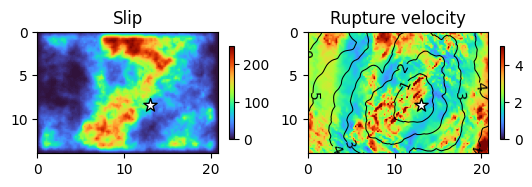

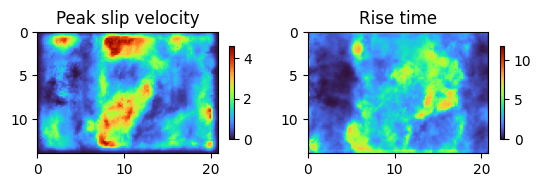

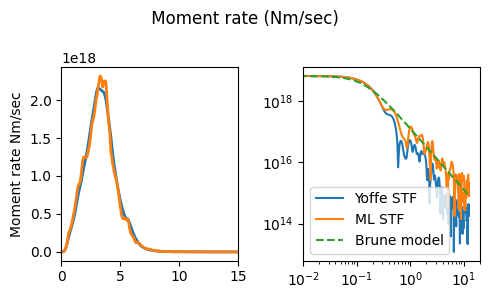

In [12]:

graph1, (plot1, plot2) = plt.subplots(1, 2)

ax = plot1.imshow(np.flipud(slip_taper),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(slip_taper)))
levels = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plot1.set_title('Slip')
plot1.scatter(hypo_x,hypo_z,100,c='w',marker='*',edgecolors='k')
plot1.yaxis.set_inverted(True)

graph1.colorbar(ax,shrink=0.25) 

ax= plot2.imshow(np.flipud(vr_new),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,5))
plot2.yaxis.set_inverted(True)
plot2.scatter(hypo_x,hypo_z,100,c='w',marker='*',edgecolors='k')
CS = plot2.contour(lx,lz,t_onset, levels,colors=['black'],linewidths=0.75)
plot2.clabel(CS)
plot2.set_title('Rupture velocity')
graph1.colorbar(ax,shrink=0.25)

# Tr and PSV

graph1, (plot1, plot2) = plt.subplots(1, 2)

ax = plot1.imshow(np.flipud(Vmax_new1),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(Vmax_new1)))
plot1.set_title('Peak slip velocity')
graph1.colorbar(ax,shrink=0.25) 
plot1.yaxis.set_inverted(True)

ax = plot2.imshow(np.flipud(Tr_new1),cmap='turbo',extent =[lx.min(), 
                                      lx.max(), 
                                      lz.min(), 
                                      lz.max()], clim=(0,np.max(Tr_new0)))
plot2.set_title('Rise time')
graph1.colorbar(ax,shrink=0.25) 
plot2.yaxis.set_inverted(True)

## MTF and spectra

plot_mtf_rate(slip_time,slip_rate_yoffe,slip_rate_ml1,samp)

